# Class, Race, and Sex in Virginia Criminal Courts

This [notebook](http://www.nature.com/news/interactive-notebooks-sharing-the-code-1.16261) is supplemental material for a blog post I am in the process of writing. Once I'm done, I'll provide a link here. If you haven't read it yet, please take a moment and start there.

If you're new to notebooks, check out this [quick start guide](https://github.com/colarusso/measured_justice/blob/master/README.md#download-install-and-run-notebooks). Also, I've tried to provide useful links for people new to this sort of thing throughout. 

## Load Modules

These are libraries we'll need to conduct our analysis.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from IPython.display import Image

## Data Wrangling & Exploration

All of our court data will be coming from here: [VA Court Data](http://virginiacourtdata.org/), maintained by Ben Schoenfeld ([@oilytheotter](https://twitter.com/oilytheotter)). As the blog post makes clear, we'll be restricting our analysis to 2006-2010. So we'll start by loading data for that timeframe. 

FYI, you'll notice that I'm referencing a directory not contained in this repo (i.e., ../data/). I did this so I don't have to worry about any of the headaces that come with hosting such data in a publicly accessable repository. See note on data privacy [link to come].  

In [2]:
# read in data
list_ = []
i = 0
yr = 2006
while yr <= 2010:
    k = 0
    while k < 12:
        k += 1  
        #print ("loading: ../data/criminal_circuit_court_cases_%s/criminal_circuit_court_cases_%s_%s.csv"%(yr,yr,k))
        list_.append(pd.read_csv("../data/criminal_circuit_court_cases_%s/criminal_circuit_court_cases_%s_%s.csv"%(yr,yr,k), low_memory=False))
        i += 1  
    yr += 1  
charges_df = pd.concat(list_)

# display first 4 rows
# charges_df[:4]

The reason we're focused on 2006-2010 is that we can use defendant zip codes to join our court data with American Community Survey (ACS) data on income. So we below we'll pull out defendant zip codes and place them in their own column. To do this we use some magic known as [regular expressions](http://codingforlawyers.com/chapters/ch1/). 

In [3]:
# Pull out zipcode to match with census data 
charges_df['Zip'] = charges_df['Address'].str.extract('([0-9]*$)', expand=False)
# drop charges where zip can't be found
charges_df = charges_df[pd.notnull(charges_df['Zip'])]
# Make sure the zip is a number
charges_df['Zip'] = pd.to_numeric(charges_df['Zip'])
# fill in NaN (blank cells) to ease later work
charges_df = charges_df.fillna(value="")
# print new count

So now we need that income data. I found a nice spreadsheet with it over here: [Zip Code Characteristics](http://www.psc.isr.umich.edu/dis/census/Features/tract2zip/). Note the file `MedianZIP-3.xlsx` actually contained both mean and media values. Anywho, I downloaded the spreadsheet and saved it as a .csv called `zip_income.csv`. Then I cleaned it up a bit.

In [4]:
# Load the csv file into a dataframe
zip_df = pd.read_csv("../data/zip_income.csv") 
# There were commas in the data. So let's strip those out. 
zip_df['Median'] = zip_df['Median'].str.replace(',', '')
zip_df['Mean'] = zip_df['Mean'].str.replace(',', '')
# Also, we won't need the population column. So let's drop that too.
zip_df = zip_df.drop('Pop', 1)
# Exclude zip codes not in VA see http://www.zipcodestogo.com/Virginia/
zip_df = zip_df[zip_df['Zip']>=20101]
zip_df = zip_df[zip_df['Zip']!=23909] # note there was an error in this entry so I had to remove it
zip_df = zip_df[zip_df['Zip']<=26886]
zip_df['Mean'] = pd.to_numeric(zip_df['Mean'])
zip_df['Median'] = pd.to_numeric(zip_df['Median'])
zip_df[:4]

,Zip,Median,Mean
6027,20105,136228,163021
6028,20106,73043,91799
6029,20109,66077,75929
6030,20110,79914,91429


So now we need to construct some features. Again, the blog post has more context. Note, here are some explinations of charge types: [Virginia Misdemeanor Crimes by Class and Sentences](http://www.criminaldefenselawyer.com/resources/virginia-misdemeanor-crimes-class-and-sentences.htm) and [Virginia Felony Crimes by Class and Sentences](http://www.criminaldefenselawyer.com/resources/criminal-defense/state-felony-laws/virginia-felony-class.htm). Also, if you're unfamiliar with the idea of joins here's [a primer with visuals](http://www.codeproject.com/Articles/33052/Visual-Representation-of-SQL-Joins). It's talking about SQL, but the concept holds.

In [5]:
# merge original data set and ACS data. THis is a join
munged_df = pd.merge(charges_df,zip_df,how='inner',on='Zip')

# Translate charge types into positions on an ordered list from 1 and 10 
munged_df['Seriousness'] = 0
munged_df.loc[(munged_df['ChargeType'].str.contains('Misdemeanor',case=False)==True) & (munged_df['Class'].str.contains('1',case=False)==True), 'Seriousness'] = 4
munged_df.loc[(munged_df['ChargeType'].str.contains('Misdemeanor',case=False)==True) & (munged_df['Class'].str.contains('2',case=False)==True), 'Seriousness'] = 3
munged_df.loc[(munged_df['ChargeType'].str.contains('Misdemeanor',case=False)==True) & (munged_df['Class'].str.contains('3',case=False)==True), 'Seriousness'] = 2
munged_df.loc[(munged_df['ChargeType'].str.contains('Misdemeanor',case=False)==True) & (munged_df['Class'].str.contains('4',case=False)==True), 'Seriousness'] = 1
munged_df.loc[(munged_df['ChargeType'].str.contains('Felony',case=False)==True) & (munged_df['Class'].str.contains('1',case=False)==True), 'Seriousness'] = 10
munged_df.loc[(munged_df['ChargeType'].str.contains('Felony',case=False)==True) & (munged_df['Class'].str.contains('2',case=False)==True), 'Seriousness'] = 9
munged_df.loc[(munged_df['ChargeType'].str.contains('Felony',case=False)==True) & (munged_df['Class'].str.contains('3',case=False)==True), 'Seriousness'] = 8
munged_df.loc[(munged_df['ChargeType'].str.contains('Felony',case=False)==True) & (munged_df['Class'].str.contains('4',case=False)==True), 'Seriousness'] = 7
munged_df.loc[(munged_df['ChargeType'].str.contains('Felony',case=False)==True) & (munged_df['Class'].str.contains('5',case=False)==True), 'Seriousness'] = 6
munged_df.loc[(munged_df['ChargeType'].str.contains('Felony',case=False)==True) & (munged_df['Class'].str.contains('6',case=False)==True), 'Seriousness'] = 5
munged_df = munged_df[munged_df['Seriousness'] > 0]

# Break out each race category so they can be considered by the linear regression
munged_df['Male'] = 0
munged_df.loc[munged_df['Sex'] == 'Male', 'Male'] = 1
munged_df['Native'] = 0
munged_df.loc[munged_df['Race'].str.contains('american',case=False)==True, 'Native'] = 1
munged_df['Asian'] = 0
munged_df.loc[munged_df['Race'].str.contains('asian',case=False)==True, 'Asian'] = 1
munged_df['Black'] = 0
munged_df.loc[munged_df['Race'].str.contains('black',case=False)==True, 'Black'] = 1
munged_df['Hispanic'] = 0
munged_df.loc[munged_df['Race'] == 'Hispanic', 'Hispanic'] = 1
munged_df['Other'] = 0
munged_df.loc[munged_df['Race'].str.contains('other',case=False)==True, 'Other'] = 1

# figure out what our sentece should be. Note: originally I was dooing more than renaming. So this is really some vestigle code. 
munged_df['SentenceDays'] = pd.to_numeric(munged_df['SentenceTimeDays'])
munged_df['SentenceDays_T'] = np.log(1+munged_df['SentenceDays'])
munged_df = munged_df.fillna(value=0)

# partition data for cross-validation
holdout = munged_df.sample(frac=0.2)
training = munged_df.loc[~munged_df.index.isin(holdout.index)]

# optional print to file
#munged_df.to_csv(path_or_buf='../data/output.csv')

#output_sample = munged_df[(munged_df['Seriousness'] <= 2) & (munged_df['SentenceDays'] > 0)]
#output_sample = munged_df.sample(n=5000)
#output_sample.to_csv(path_or_buf='../data/output_sample.csv')

# display first four rows
munged_df[:4]

,AKA,AKA2,Address,AmendedCharge,AmendedChargeType,AmendedCodeSection,ArrestDate,CaseNumber,Charge,ChargeType,...,Mean,Seriousness,Male,Native,Asian,Black,Hispanic,Other,SentenceDays,SentenceDays_T
0,,,"TOPPING, VA 23169",DIST.MARIJ.<1/2 OZ.,Misdemeanor,18.2-248.1,10/25/2005,CR04003010-01,DIST.MARIJUANA,Felony,...,57734,6,1,0,1,0,0,0,365.0,5.902633
8,,,"TOPPING, VA 23169",,,,02/27/2005,CR05000044-00,DRIVING INTOXICATED,Misdemeanor,...,57734,4,1,0,1,0,0,0,0.0,0.000000
9,,,"TOPPING, VA 23169",,,,06/22/2005,CR05000106-00,POSS. FIREARM BY FELON,Felony,...,57734,5,1,0,1,0,0,0,1825.0,7.509883
11,,,"TOPPING, VA 23169",,,,,CR06000069-00,RECKLESS DRIVING 84/65 MPH,Misdemeanor,...,57734,4,1,0,1,0,0,0,0.0,0.000000


## Analysis 

If you're not familiar with linear regressions, read the blog post then check out this: [Introduction to Linear Regression](https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb).

P-values:
Intercept      0.0
Seriousness    0.0
dtype: float64


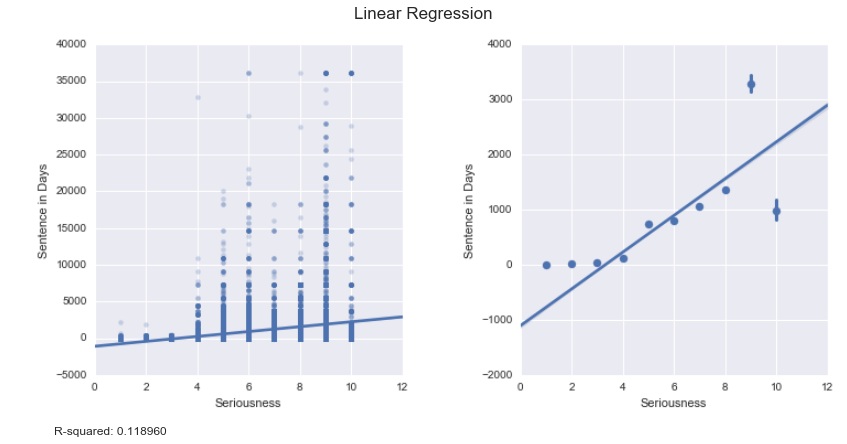

In [6]:
# Run a simple linear regression & print the P values
model = ols("SentenceDays ~ Seriousness", training).fit()
print("P-values:\n%s"%model.pvalues)

# Plot multiple subplot axes with seaborn
# h/t https://gist.github.com/JohnGriffiths/8605267
fig_outfile = '../data/tmp/fig_1.png'

# Plot the figs and save to temp files
fig = sns.lmplot(x="Seriousness", y="SentenceDays", data=munged_df, scatter_kws={"s": 20, "alpha": 0.25}, order=1)
fig = (fig.set_axis_labels("Seriousness", "Sentence in Days"))
plt.savefig('../data/tmp/f1.1.png',bbox_inches='tight'); plt.close()
fig = sns.lmplot(x="Seriousness", y="SentenceDays", data=munged_df, x_estimator=np.mean, order=1)
fig = (fig.set_axis_labels("Seriousness", "Sentence in Days"))
plt.savefig('../data/tmp/f1.2.png',bbox_inches='tight'); plt.close()

# Combine them with imshows
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
for a in [1,2]: ax[a-1].imshow(plt.imread('../data/tmp/f1.%s.png' %a)); ax[a-1].axis('off')
plt.suptitle("Linear Regression",  fontsize = 17)
plt.tight_layout(); plt.subplots_adjust(top=0.92)
plt.annotate('R-squared: %f'%(model.rsquared), (-1.05,0), (0,-10), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig(fig_outfile,bbox_inches='tight'); 
plt.close() 

# Display in notebook as an image
Image(fig_outfile, width="100%")

P-values:
Intercept                    3.793973e-80
Seriousness                  8.925109e-31
np.power(Seriousness, 2)    1.096301e-113
dtype: float64
P values:
Intercept                   1.221946e-06
Seriousness                 9.431874e-06
np.power(Seriousness, 2)    5.982796e-09
np.power(Seriousness, 3)    3.620690e-23
np.power(Seriousness, 4)    1.048774e-34
dtype: float64


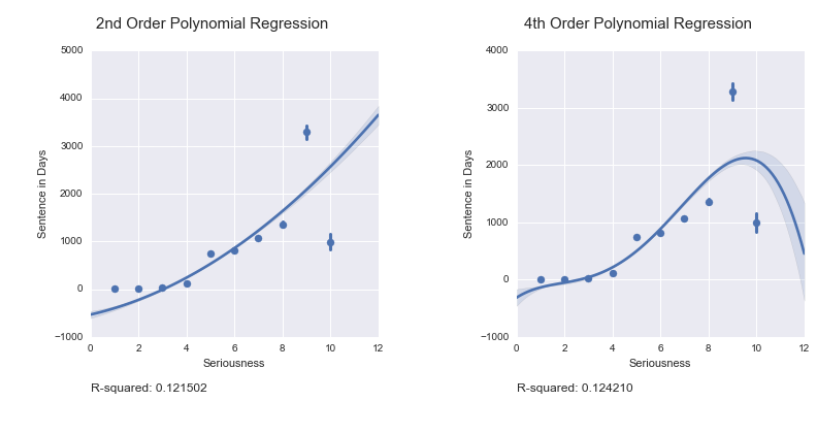

In [7]:
# Run a simple linear regression & print the P values
model = ols("SentenceDays ~ Seriousness + np.power(Seriousness, 2)", training).fit()
print("P-values:\n%s"%model.pvalues)

# Plot multiple subplot axes with seaborn
# h/t https://gist.github.com/JohnGriffiths/8605267
fig_outfile = '../data/tmp/fig_1.5.png'

# Plot the figs and save to temp files
fig = sns.lmplot(x="Seriousness", y="SentenceDays", data=munged_df, x_estimator=np.mean, order=2);
fig = (fig.set_axis_labels("Seriousness", "Sentence in Days"))
plt.suptitle("2nd Order Polynomial Regression",  fontsize = 15)
plt.subplots_adjust(top=0.89)
plt.annotate('R-squared: %f'%(model.rsquared), (0,0), (0,-45), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig('../data/tmp/f1.5.1.png',bbox_inches='tight'); plt.close()
model = ols("SentenceDays ~ Seriousness + np.power(Seriousness, 2) + np.power(Seriousness, 3)+ np.power(Seriousness, 4)", munged_df).fit()
print("P values:\n%s"%model.pvalues)
fig = sns.lmplot(x="Seriousness", y="SentenceDays", data=munged_df, x_estimator=np.mean, order=4);
fig = (fig.set_axis_labels("Seriousness", "Sentence in Days"))
plt.suptitle("4th Order Polynomial Regression",  fontsize = 15)
plt.subplots_adjust(top=0.89)
plt.annotate('R-squared: %f'%(model.rsquared), (0,0), (0,-45), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig('../data/tmp/f1.5.2.png',bbox_inches='tight'); plt.close()

# Combine them with imshows
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
for a in [1,2]: ax[a-1].imshow(plt.imread('../data/tmp/f1.5.%s.png' %a)); ax[a-1].axis('off')
plt.tight_layout(); plt.savefig(fig_outfile,bbox_inches='tight'); plt.close() 

# Display in notebook as an image
Image(fig_outfile, width="100%")

P-values:
Intercept      5.177655e-114
Seriousness     0.000000e+00
dtype: float64


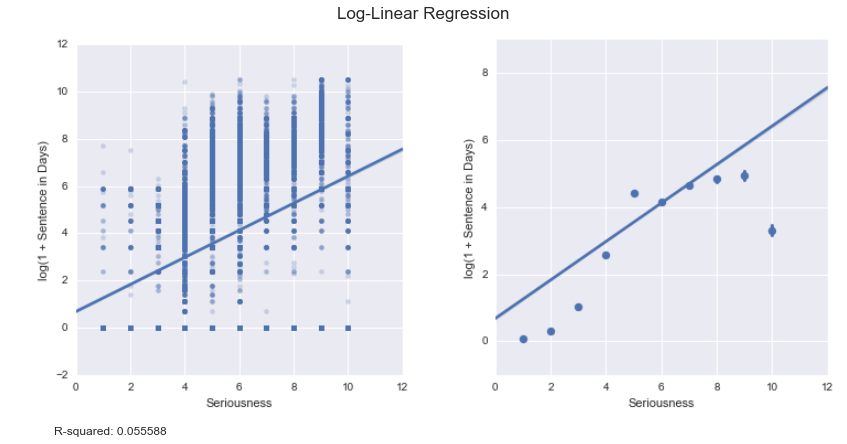

In [8]:
# Run a simple linear regression & print the P values
model = ols("SentenceDays_T ~ Seriousness", training).fit()
print("P-values:\n%s"%model.pvalues)

# Plot multiple subplot axes with seaborn
# h/t https://gist.github.com/JohnGriffiths/8605267
fig_outfile = '../data/tmp/fig_2.png'

# Plot the figs and save to temp files
fig = sns.lmplot(x="Seriousness", y="SentenceDays_T", data=munged_df, scatter_kws={"s": 20, "alpha": 0.25}, order=1);
fig = (fig.set_axis_labels("Seriousness", "log(1 + Sentence in Days)"))
plt.savefig('../data/tmp/f2.1.png',bbox_inches='tight'); plt.close()
fig = sns.lmplot(x="Seriousness", y="SentenceDays_T", data=munged_df, x_estimator=np.mean, order=1);
fig = (fig.set_axis_labels("Seriousness", "log(1 + Sentence in Days)"))
plt.savefig('../data/tmp/f2.2.png',bbox_inches='tight'); plt.close()

# Combine them with imshows
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
for a in [1,2]: ax[a-1].imshow(plt.imread('../data/tmp/f2.%s.png' %a)); ax[a-1].axis('off')
plt.suptitle("Log-Linear Regression",  fontsize = 17)
plt.tight_layout(); plt.subplots_adjust(top=0.92)
plt.annotate('R-squared: %f'%(model.rsquared), (-1.05,0), (0,-10), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig(fig_outfile,bbox_inches='tight'); plt.close() 

# Display in notebook as an image
Image(fig_outfile, width="100%")

P-values:
Intercept                   0.0
Seriousness                 0.0
np.power(Seriousness, 2)    0.0
dtype: float64


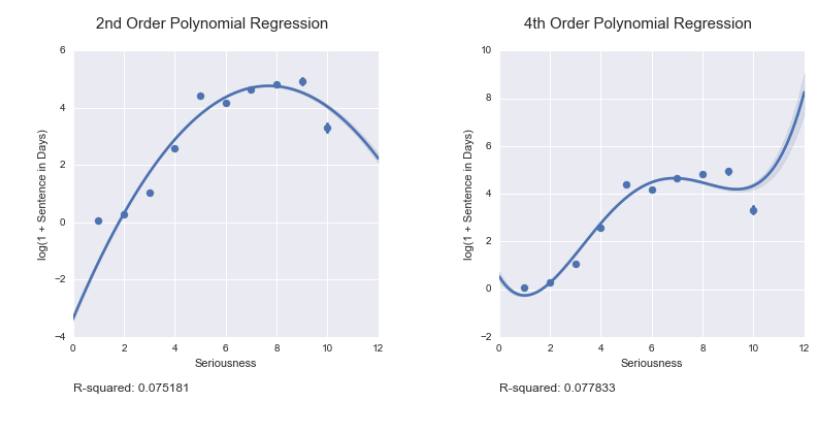

In [9]:
# Run a simple linear regression & print the P values
model = ols("SentenceDays_T ~ Seriousness + np.power(Seriousness, 2)", training).fit()
print("P-values:\n%s"%model.pvalues)

# Plot multiple subplot axes with seaborn
# h/t https://gist.github.com/JohnGriffiths/8605267
fig_outfile = '../data/tmp/fig_3.png'

# Plot the figs and save to temp files
fig = sns.lmplot(x="Seriousness", y="SentenceDays_T", data=munged_df, x_estimator=np.mean, order=2);
fig = (fig.set_axis_labels("Seriousness", "log(1 + Sentence in Days)"))
plt.suptitle("2nd Order Polynomial Regression",  fontsize = 15)
plt.subplots_adjust(top=0.89)
plt.annotate('R-squared: %f'%(model.rsquared), (0,0), (0,-45), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig('../data/tmp/f3.1.png',bbox_inches='tight'); plt.close()
model = ols("SentenceDays_T ~ Seriousness + np.power(Seriousness, 2) + np.power(Seriousness, 3)+ np.power(Seriousness, 4)", munged_df).fit()
fig = sns.lmplot(x="Seriousness", y="SentenceDays_T", data=munged_df, x_estimator=np.mean, order=4);
fig = (fig.set_axis_labels("Seriousness", "log(1 + Sentence in Days)"))
plt.suptitle("4th Order Polynomial Regression",  fontsize = 15)
plt.subplots_adjust(top=0.89)
plt.annotate('R-squared: %f'%(model.rsquared), (0,0), (0,-45), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig('../data/tmp/f3.2.png',bbox_inches='tight'); plt.close()

# Combine them with imshows
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
for a in [1,2]: ax[a-1].imshow(plt.imread('../data/tmp/f3.%s.png' %a)); ax[a-1].axis('off')
plt.tight_layout(); plt.savefig(fig_outfile,bbox_inches='tight'); plt.close() 

# Display in notebook as an image
Image(fig_outfile, width="100%")

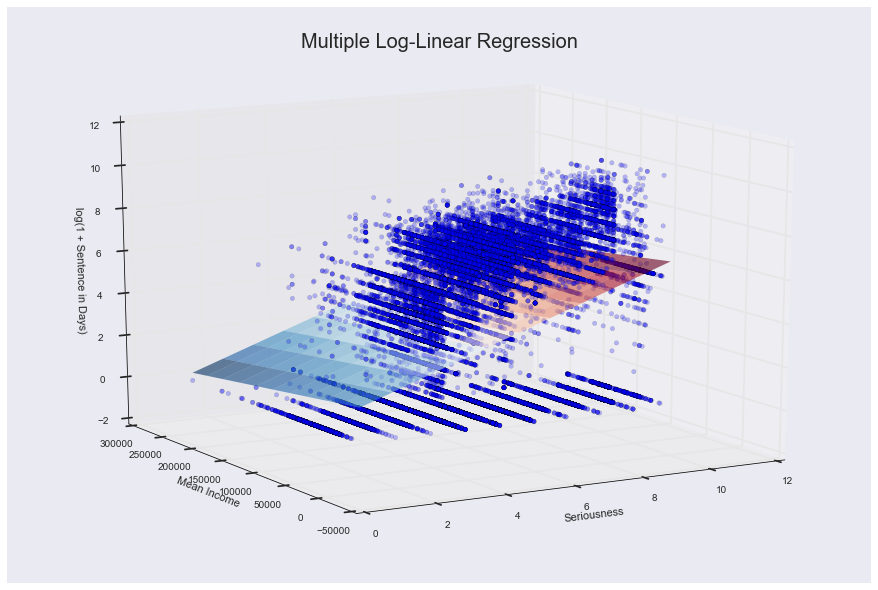

In [10]:
# Plot multiple linear regression 
# h/t https://www.datarobot.com/blog/multiple-regression-using-statsmodels/#appendix

from mpl_toolkits.mplot3d import Axes3D

X = training[['Seriousness', 'Mean']]
y = training['SentenceDays_T']

## fit a OLS model
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()

## Create the 3d plot 
xx1, xx2 = np.meshgrid(np.linspace(X.Seriousness.min(), X.Seriousness.max(), 100), 
                       np.linspace(X.Mean.min(), X.Mean.max(), 100))

# plot the hyperplane by evaluating the parameters on the grid
Z = est.params[0] + est.params[1] * xx1 + est.params[2] * xx2

# create matplotlib 3d axes
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-120, elev=15)

# plot hyperplane
surf = ax.plot_surface(xx1, xx2, Z, cmap=plt.cm.RdBu_r, alpha=0.6, linewidth=0)

# plot data points
resid = y - est.predict(X)
ax.scatter(X[resid >= 0].Seriousness, X[resid >= 0].Mean, y[resid >= 0], color='black', alpha=0.25, facecolor='white')
ax.scatter(X[resid < 0].Seriousness, X[resid < 0].Mean, y[resid < 0], color='black', alpha=0.25)

# set axis labels
ax.set_title('Multiple Log-Linear Regression', fontsize = 20)
ax.set_xlabel('Seriousness')
ax.set_ylabel('Mean Income')
ax.set_zlabel('log(1 + Sentence in Days)')

## Cross Validation

So the code below doesn't really capture how I go about cross-validation, but as a supplement to the blog post, I wanted to provide a look at how one might compare multiple models. Below you'll see summary statistics from sets of different regressions run both on the training and holdout data. A good description of the summary statistics can be found in this article: [Linear Regressuib with Python](http://connor-johnson.com/2014/02/18/linear-regression-with-python/).

You'll also notice a graph associated with each regression. These a residual plots, and the folowing article should help you understand how to read them. [Interpreting residual plots to improve your regression](http://docs.statwing.com/interpreting-residual-plots-to-improve-your-regression/).




         LINEAR
                            OLS Regression Results                            
Dep. Variable:           SentenceDays   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     3149.
Date:                Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                        19:16:15   Log-Likelihood:            -1.5154e+06
No. Observations:              177764   AIC:                         3.031e+06
Df Residuals:                  177755   BIC:                         3.031e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept   -1244.0342     81.276 

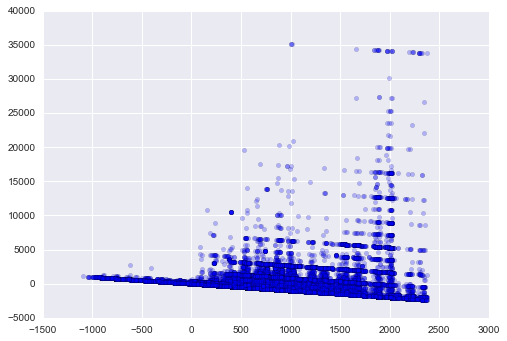

                            OLS Regression Results                            
Dep. Variable:           SentenceDays   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     790.7
Date:                Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                        19:16:17   Log-Likelihood:            -3.7879e+05
No. Observations:               44441   AIC:                         7.576e+05
Df Residuals:                   44432   BIC:                         7.577e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept   -1251.2201    159.078     -7.865      

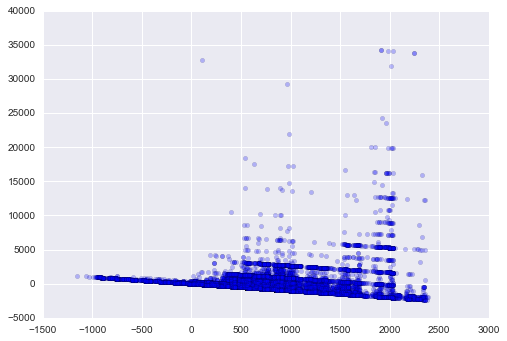

       2ND ORDER
                            OLS Regression Results                            
Dep. Variable:           SentenceDays   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     2856.
Date:                Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                        19:16:18   Log-Likelihood:            -1.5151e+06
No. Observations:              177764   AIC:                         3.030e+06
Df Residuals:                  177754   BIC:                         3.030e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Interce

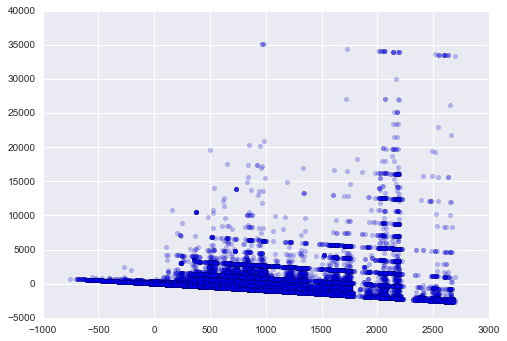

                            OLS Regression Results                            
Dep. Variable:           SentenceDays   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     716.0
Date:                Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                        19:16:19   Log-Likelihood:            -3.7874e+05
No. Observations:               44441   AIC:                         7.575e+05
Df Residuals:                   44431   BIC:                         7.576e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

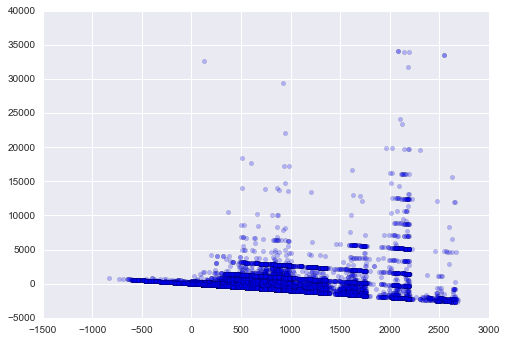

       4TH ORDER
                            OLS Regression Results                            
Dep. Variable:           SentenceDays   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     2856.
Date:                Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                        19:16:20   Log-Likelihood:            -1.5151e+06
No. Observations:              177764   AIC:                         3.030e+06
Df Residuals:                  177754   BIC:                         3.030e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Interce

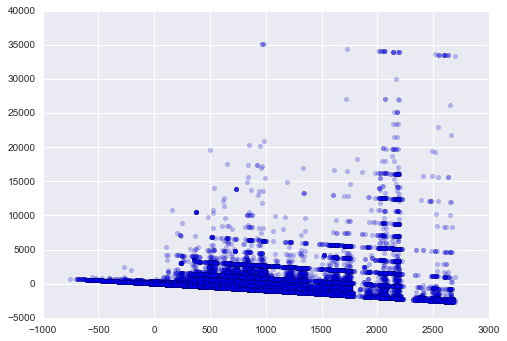

                            OLS Regression Results                            
Dep. Variable:           SentenceDays   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     716.0
Date:                Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                        19:16:22   Log-Likelihood:            -3.7874e+05
No. Observations:               44441   AIC:                         7.575e+05
Df Residuals:                   44431   BIC:                         7.576e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               

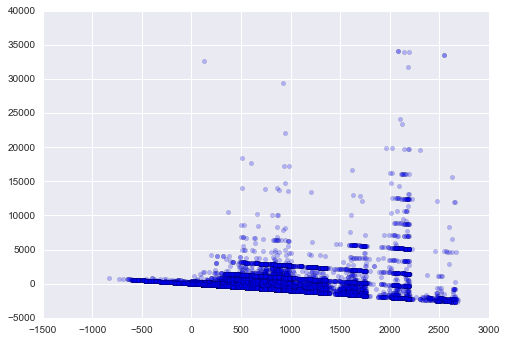

      LOG-LINEAR
                               OLS Regression Results                               
Dep. Variable:     np.log(1 + SentenceDays)   R-squared:                       0.061
Model:                                  OLS   Adj. R-squared:                  0.061
Method:                       Least Squares   F-statistic:                     1441.
Date:                      Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                              19:16:23   Log-Likelihood:            -4.5763e+05
No. Observations:                    177764   AIC:                         9.153e+05
Df Residuals:                        177755   BIC:                         9.154e+05
Df Model:                                 8                                         
Covariance Type:                  nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------

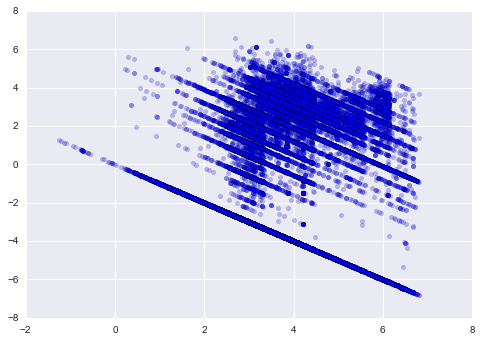

                               OLS Regression Results                               
Dep. Variable:     np.log(1 + SentenceDays)   R-squared:                       0.060
Model:                                  OLS   Adj. R-squared:                  0.060
Method:                       Least Squares   F-statistic:                     352.8
Date:                      Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                              19:16:24   Log-Likelihood:            -1.1443e+05
No. Observations:                     44441   AIC:                         2.289e+05
Df Residuals:                         44432   BIC:                         2.290e+05
Df Model:                                 8                                         
Covariance Type:                  nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------

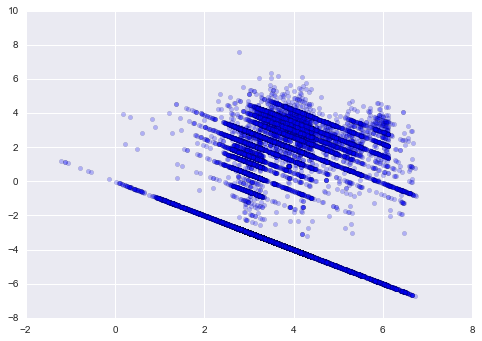

  2ND ORDER LOG-LINEAR
                               OLS Regression Results                               
Dep. Variable:     np.log(1 + SentenceDays)   R-squared:                       0.081
Model:                                  OLS   Adj. R-squared:                  0.081
Method:                       Least Squares   F-statistic:                     1744.
Date:                      Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                              19:16:25   Log-Likelihood:            -4.5569e+05
No. Observations:                    177764   AIC:                         9.114e+05
Df Residuals:                        177754   BIC:                         9.115e+05
Df Model:                                 9                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------

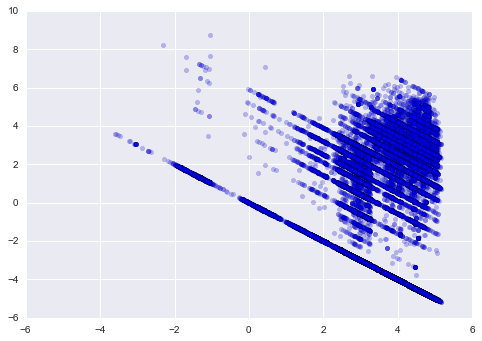

                               OLS Regression Results                               
Dep. Variable:     np.log(1 + SentenceDays)   R-squared:                       0.080
Model:                                  OLS   Adj. R-squared:                  0.080
Method:                       Least Squares   F-statistic:                     431.0
Date:                      Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                              19:16:27   Log-Likelihood:            -1.1394e+05
No. Observations:                     44441   AIC:                         2.279e+05
Df Residuals:                         44431   BIC:                         2.280e+05
Df Model:                                 9                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------

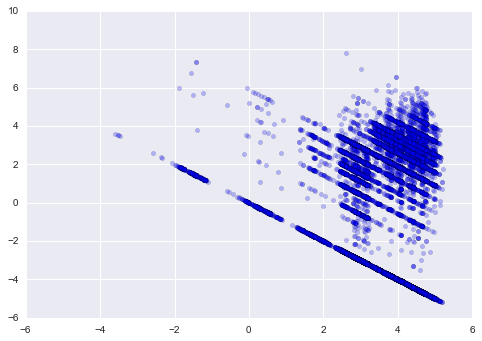

  4TH ORDER LOG-LINEAR
                               OLS Regression Results                               
Dep. Variable:     np.log(1 + SentenceDays)   R-squared:                       0.081
Model:                                  OLS   Adj. R-squared:                  0.081
Method:                       Least Squares   F-statistic:                     1744.
Date:                      Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                              19:16:28   Log-Likelihood:            -4.5569e+05
No. Observations:                    177764   AIC:                         9.114e+05
Df Residuals:                        177754   BIC:                         9.115e+05
Df Model:                                 9                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------

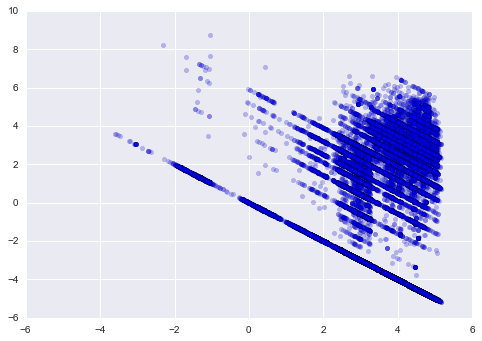

                               OLS Regression Results                               
Dep. Variable:     np.log(1 + SentenceDays)   R-squared:                       0.080
Model:                                  OLS   Adj. R-squared:                  0.080
Method:                       Least Squares   F-statistic:                     431.0
Date:                      Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                              19:16:29   Log-Likelihood:            -1.1394e+05
No. Observations:                     44441   AIC:                         2.279e+05
Df Residuals:                         44431   BIC:                         2.280e+05
Df Model:                                 9                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------

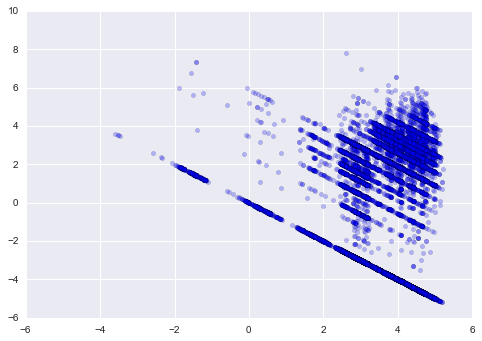

In [11]:
print("========================")
print("         LINEAR")
print("========================")
model = ols("SentenceDays ~ Seriousness + Male + Mean + Black + Hispanic + Asian + Native + Other", training).fit()
print(model.summary())
plt.scatter(model.fittedvalues,model.resid,alpha=0.25)
plt.show()
model = ols("SentenceDays ~ Seriousness + Male + Mean + Black + Hispanic + Asian + Native + Other", holdout).fit()
print(model.summary())
plt.scatter(model.fittedvalues,model.resid,alpha=0.25)
plt.show()

print("========================")
print("       2ND ORDER")
print("========================")
model = ols("SentenceDays ~ Seriousness + np.power(Seriousness, 2) + Male + Mean + Black + Hispanic + Asian + Native + Other", training).fit()
print(model.summary())
plt.scatter(model.fittedvalues,model.resid,alpha=0.25)
plt.show()
model = ols("SentenceDays ~ Seriousness + np.power(Seriousness, 2) + Male + Mean + Black + Hispanic + Asian + Native + Other", holdout).fit()
print(model.summary())
plt.scatter(model.fittedvalues,model.resid,alpha=0.25)
plt.show()

print("========================")
print("       4TH ORDER")
print("========================")
model = ols("SentenceDays ~ Seriousness + np.power(Seriousness, 2) + Male + Mean + Black + Hispanic + Asian + Native + Other", training).fit()
print(model.summary())
plt.scatter(model.fittedvalues,model.resid,alpha=0.25)
plt.show()
model = ols("SentenceDays ~ Seriousness + np.power(Seriousness, 2) + Male + Mean + Black + Hispanic + Asian + Native + Other", holdout).fit()
print(model.summary())
plt.scatter(model.fittedvalues,model.resid,alpha=0.25)
plt.show()

print("========================")
print("      LOG-LINEAR")
print("========================")
model = ols("np.log(1+SentenceDays) ~ Seriousness + Male + Mean + Black + Hispanic + Asian + Native + Other", training).fit()
print(model.summary())
plt.scatter(model.fittedvalues,model.resid,alpha=0.25)
plt.show()
model = ols("np.log(1+SentenceDays) ~ Seriousness + Male + Mean + Black + Hispanic + Asian + Native + Other", holdout).fit()
print(model.summary())
plt.scatter(model.fittedvalues,model.resid,alpha=0.25)
plt.show()

print("========================")
print("  2ND ORDER LOG-LINEAR")
print("========================")
model = ols("np.log(1+SentenceDays) ~ Seriousness + np.power(Seriousness, 2) + Male + Mean + Black + Hispanic + Asian + Native + Other", training).fit()
print(model.summary())
plt.scatter(model.fittedvalues,model.resid,alpha=0.25)
plt.show()
model = ols("np.log(1+SentenceDays) ~ Seriousness + np.power(Seriousness, 2) + Male + Mean + Black + Hispanic + Asian + Native + Other", holdout).fit()
print(model.summary())
plt.scatter(model.fittedvalues,model.resid,alpha=0.25)
plt.show()

print("========================")
print("  4TH ORDER LOG-LINEAR")
print("========================")
model = ols("np.log(1+SentenceDays) ~ Seriousness + np.power(Seriousness, 2) + Male + Mean + Black + Hispanic + Asian + Native + Other", training).fit()
print(model.summary())
plt.scatter(model.fittedvalues,model.resid,alpha=0.25)
plt.show()
model = ols("np.log(1+SentenceDays) ~ Seriousness + np.power(Seriousness, 2) + Male + Mean + Black + Hispanic + Asian + Native + Other", holdout).fit()
print(model.summary())
plt.scatter(model.fittedvalues,model.resid,alpha=0.25)
plt.show()

# The Final Word

In the blog post I make use of a model to calculate how much money a person of color would need to earn in order to counteract race-base bias with class-based favor. The model below is the one I used. You'll note its a little different that the ones found above. Mostly, I opted to go with a log-linear model. This is in part because of its simplicity. As the post makes clear, I only need the model to be good enough to answer the question I'm asking (i.e., which is a bigger problem for the criminal justice system, race or class based bias?). And it has to be easily to explain the model to a general audience. That being said, this doesn't have to be the final word. Please take this work and expand on it. Just let me know how it goes. 

Anywho, you'll notice that this model doesn't have the highest R-squared of the set. That's because I liked its residual plot better than the linear models with better R-squareds. As for the choice not to fit a polynomial, I didn't feel like I had very good theory to support such agressive fitting, and again, I'm just looking for an answer to my question, not a predictive model. That is, I'm modeling for insight. So I have a high tolerance for minor differences.

In [12]:
model = ols("np.log(1+SentenceDays) ~ Seriousness + Male + Mean + Black + Hispanic + Asian + Native + Other", munged_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     np.log(1 + SentenceDays)   R-squared:                       0.061
Model:                                  OLS   Adj. R-squared:                  0.061
Method:                       Least Squares   F-statistic:                     1794.
Date:                      Tue, 26 Apr 2016   Prob (F-statistic):               0.00
Time:                              19:16:30   Log-Likelihood:            -5.7206e+05
No. Observations:                    222205   AIC:                         1.144e+06
Df Residuals:                        222196   BIC:                         1.144e+06
Df Model:                                 8                                         
Covariance Type:                  nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      -1.5302      0.189     -8.113      0.000        -1.900    -1.161
Seriousness     0.5650      0.005    112.727      0.000         0.555     0.575
Male            0.3285      0.015     21.451      0.000         0.299     0.359
Mean        -4.171e-06   2.83e-07    -14.716      0.000     -4.73e-06 -3.62e-06
Black           2.4098      0.187     12.886      0.000         2.043     2.776
Hispanic        2.3992      0.198     12.140      0.000         2.012     2.787
Asian           2.2191      0.187     11.878      0.000         1.853     2.585
Native          2.4219      0.326      7.425      0.000         1.783     3.061
Other           1.1701      0.213      5.498      0.000         0.753     1.587
==============================================================================
Omnibus:                     2078.029   Durbin-Watson:                   1.384
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26011.375
Skew:                          -0.240   Prob(JB):                         0.00
Kurtosis:                       1.394   Cond. No.                     4.83e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.83e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Here's the above model translated into an equation. 

## $$S = e^{\beta + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4 + \beta_5 x_5 + \beta_6 x_6 + \beta_7 x_7 + \beta_8 x_8 + \epsilon} \quad$$

Where: 
* D is our dataset of court cases joined with income data.
* S is the **Sentence in Days plus 1 day**
* **Coeficents** &beta;<sub>1</sub> through &beta;<sub>8</sub> are those determined by an ordinary least squares (OLS) regression for the dataset D corresponding to features x<sub>1</sub> through x<sub>8</sub> repectivly, with &beta; equal to the intercept. Values of these can be found in the table above along with P values and additional summary data. An explination of these summary statistics can be found [here](http://connor-johnson.com/2014/02/18/linear-regression-with-python/).
* &epsilon; = some **random error** for the above OLS. For more on this, consult [Forecasting From Log-Linear Regressions](http://davegiles.blogspot.com/2013/08/forecasting-from-log-linear-regressions.html)
* x<sub>1</sub> = the **seriousness** level of a charge. 
* x<sub>2</sub> = 1 if defendent is **male**, otherwise 0. 
* x<sub>3</sub> = the **mean** income of the defendent's zip code. 
* x<sub>4</sub> = 1 if defendent is **Black**, otherwise 0. 
* x<sub>5</sub> = 1 if defendent is **Hispanic**, otherwise 0. 
* x<sub>6</sub> = 1 if defendent is **Asian**, otherwise 0. 
* x<sub>7</sub> = 1 if defendent is **Native American**, otherwise 0. 
* x<sub>8</sub> = 1 if defendent is **Other**, otherwise 0. 

For income’s influence to counteract that of being black $\beta_3 x_3 + \beta_3 x_4 = 0$

Therefore:
$$ –0.000004171 x + (2.4098)(1) = 0 $$

$$ x = \frac{2.4098}{0.000004171} $$

$$ x = $577,751.139 $$

That is: 

> **For a black man in a Virginia court to get the same treatment as his Caucasian peer, he needs an annual income in excess of half a million dollars.**

The same holds for American Indians, Asian or Pacific Islanders, and Hispanics.